In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

Import needed packages then make variable of the file paths to the image folders.

In [2]:
tumor_dir = '.\Brain Tumor'
healthy_dir = '.\Healthy'

Create list of image directories then list of labels.

In [3]:
directory_list = [tumor_dir, healthy_dir]
labels_list = ['Tumor', 'Healthy']

filepaths = []
diagnosis = []

Loop through directory creating list of filepaths and the label for each

In [4]:
for directory, diag in zip(directory_list, labels_list):
    filelist = os.listdir(directory)
    for file in filelist:
        filepath = os.path.join (directory, file)
        filepaths.append(filepath)
        diagnosis.append(diag)

Change the filepaths and diagnosis lists into pandas Series

In [5]:
filepaths_series = pd.Series(filepaths, name='File_Path')
diagnosis_series = pd.Series(diagnosis, name='Diagnosis')

Convert pandas series into dataframe.

In [6]:
df = pd.concat([filepaths_series, diagnosis_series], axis=1)
array = np.array(df).reshape(4600,2)

df = pd.DataFrame(array, columns=['File_Path', 'Diagnosis'])
df.head()

,File_Path,Diagnosis
0,.\Brain Tumor\Cancer (1).jpg,Tumor
1,.\Brain Tumor\Cancer (1).png,Tumor
2,.\Brain Tumor\Cancer (1).tif,Tumor
3,.\Brain Tumor\Cancer (10).jpg,Tumor
4,.\Brain Tumor\Cancer (10).tif,Tumor


Create chart of the number of each type of image, healthy brain or brain with tumor.

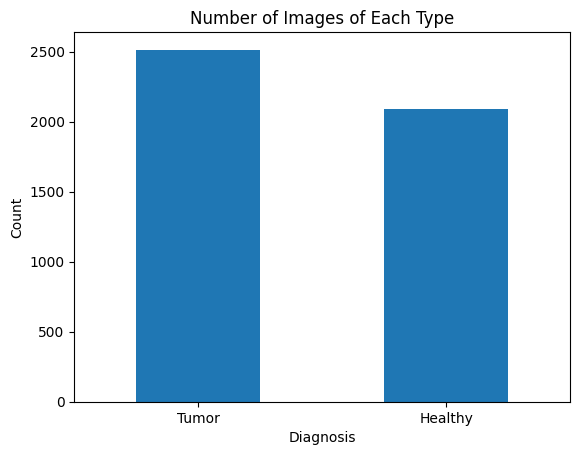

In [7]:
diagnosis2 = df['Diagnosis'].value_counts()
diagnosis2.plot(kind='bar')
plt.title('Number of Images of Each Type')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

There are slightly more images of tumors than there are images of healthy brains.

Split the images file paths into a test set and a training set.

In [8]:
train_images, test_images = train_test_split(df, test_size=0.25, random_state=47)
train_images, validation_images = train_test_split(df, test_size=0.10, random_state=47)

Perform data augmentation of the images and create two sets the training images and the test images

In [9]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [10]:
train_data = image_gen.flow_from_dataframe(train_images, x_col='File_Path', y_col='Diagnosis', shuffle=False)
test_data = image_gen.flow_from_dataframe(test_images, x_col='File_Path', y_col='Diagnosis', shuffle=False)
validation_data = image_gen.flow_from_dataframe(validation_images, x_col='File_Path', y_col='Diagnosis', shuffle=False)

Found 4140 validated image filenames belonging to 2 classes.
Found 1150 validated image filenames belonging to 2 classes.
Found 460 validated image filenames belonging to 2 classes.


Lets take a look at some of our images.

In [11]:
def show_generated_images(image_gen):
    classes = list(train_data.class_indices.keys())
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 10))

    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow((images[i]+1)/2)
        index = np.argmax(labels[i])
        
        if classes[index] == 'Tumor':
            plt.title(classes[index], color='red')
        else:
            plt.title(classes[index], color='green')

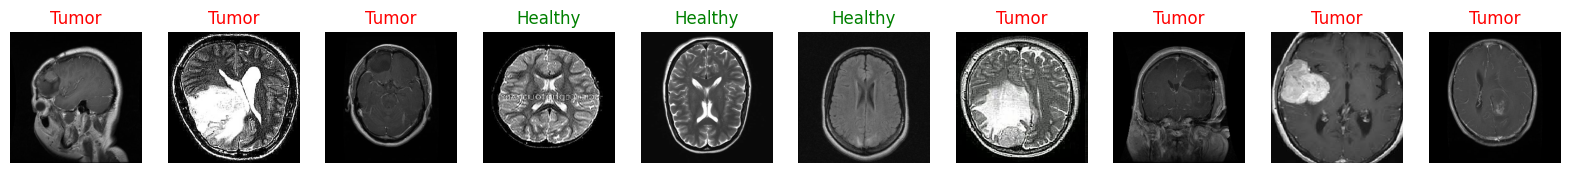

In [12]:
show_generated_images(train_data)

Now it's time to create our neural network. After some experimenting I have settled on 2 Conv2D layers, each with its own MaxPooling2D layer. After flattening there will be two dense layers, the first with a dropout rate of .3. The final dense layer will make the diagnosis.

In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(32, kernel_size=5, strides=2, activation='relu', padding='same', input_shape=(256, 256, 3)))

model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(512, activation='relu'))

model.add(Dense(2, activation='sigmoid')) 

Let's compile the model and look at the summary.

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              6

67 million parameters is a lot, so we will see if the model is too computationally expensive. I am going to use some callbacks to make sure the training doesn't take too long.

In [16]:
callbacks = [
    ModelCheckpoint('TumorPredictor.h5', save_best_only=True, verbose=0),
    EarlyStopping(patience=3, monitor='val_loss', verbose=1)
    ]

I am going to fit the model over 30 epochs with an Early Stopping callback.

In [17]:
history = model.fit(train_data, validation_data=validation_data, epochs=30, callbacks=callbacks)

Epoch 1/30
130/130 [==============================] - 62s 474ms/step - loss: 0.9372 - accuracy: 0.7700 - val_loss: 0.3844 - val_accuracy: 0.8239
Epoch 2/30
130/130 [==============================] - 60s 460ms/step - loss: 0.1690 - accuracy: 0.9360 - val_loss: 0.2040 - val_accuracy: 0.9261
Epoch 3/30
130/130 [==============================] - 57s 441ms/step - loss: 0.0693 - accuracy: 0.9758 - val_loss: 0.1372 - val_accuracy: 0.9500
Epoch 4/30
130/130 [==============================] - 56s 432ms/step - loss: 0.0521 - accuracy: 0.9831 - val_loss: 0.2370 - val_accuracy: 0.9500
Epoch 5/30
130/130 [==============================] - 57s 442ms/step - loss: 0.1003 - accuracy: 0.9734 - val_loss: 0.1216 - val_accuracy: 0.9522
Epoch 6/30
130/130 [==============================] - 57s 440ms/step - loss: 0.0571 - accuracy: 0.9802 - val_loss: 0.0978 - val_accuracy: 0.9696
Epoch 7/30
130/130 [==============================] - 57s 439ms/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0985 - val_ac

The model took about a minute per epoch to train, and stopped after 9 epochs. Now let's take a look at how the loss changed over the training epochs.

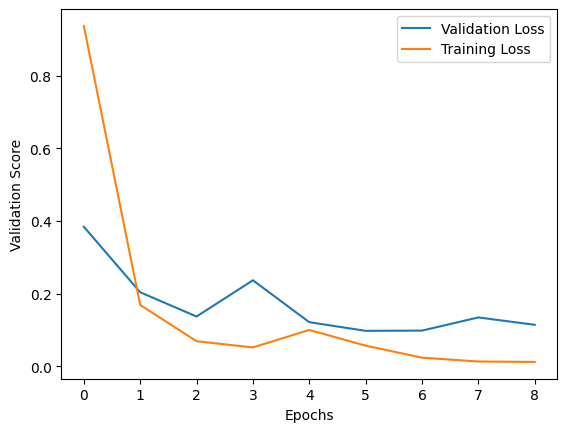

In [18]:
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.plot(history.history['loss'], label="Training Loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Score')
plt.show()

Let's do the same with accuracy.

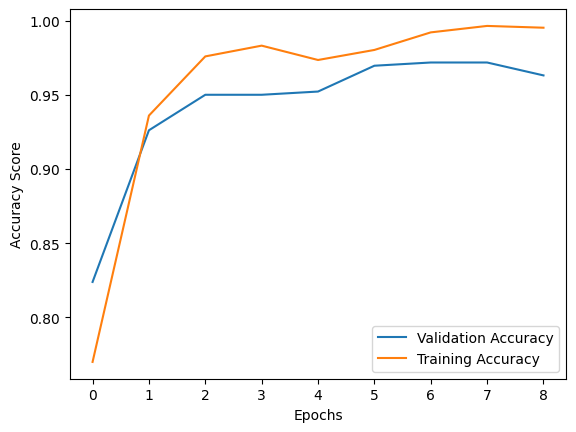

In [19]:
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.show()

I am now going to test the best model on the test data

In [20]:
best_model = model

In [21]:
best_model.load_weights('.\TumorPredictor.h5')

In [22]:
best_model.evaluate(test_data)

36/36 [==============================] - 3s 80ms/step - loss: 0.0452 - accuracy: 0.9870


[0.04523378983139992, 0.9869565367698669]

Thats 99% accuracy! Well more than my target; and it only took 3 seconds to classify about 1000 images, so it's fast too. Now let's create a classification report, and convolutional matrix.

In [23]:
pred = best_model.predict(test_data)
pred = np.argmax(pred, axis=1)

labels = (train_data.class_indices)
labels = dict((values, keys) for keys, values in labels.items())
pred = [labels[keys] for keys in pred]

y_test = test_images.Diagnosis

36/36 [==============================] - 3s 83ms/step


In [24]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     Healthy       0.99      0.98      0.99       509
       Tumor       0.98      0.99      0.99       641

    accuracy                           0.99      1150
   macro avg       0.99      0.99      0.99      1150
weighted avg       0.99      0.99      0.99      1150



<AxesSubplot:>

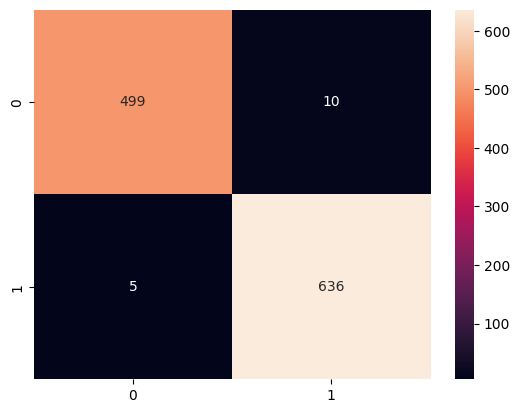

In [25]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='g')

5 false positives and 10 false negatives, I'm surprised at how well the model performed.